# Lab 1: Exploring the Catalog

**Goal**: Discover what's available

In this lab, you'll log into a pre-configured AWS SageMaker Studio environment and explore the pre-loaded data catalog (ERA5, DEM, etc.) in a Jupyter Notebook. You'll run basic Xarray queries that are accelerated by Icechunk, experiencing the platform's speed firsthand.

## Log into Sagemaker Environment

Let's first log in to the AWS SageMake Studio environment.

TODO

## Connect to Arraylake

Now let's login to arraylake. We can [login to the web app](https://app.earthmover.io/earthsciencesnz/dashboard), or log in from the notebook programatically via the client.

In [2]:
from arraylake import Client

In [3]:
client = Client()
client.login()

🔓 Successfully refreshed tokens!

> Token stored at /Users/tom/.arraylake/token.json

╭──────────────────────────────────────────────── 👤 User Details ────────────────────────────────────────────────╮
│ Name: Tom Nicholas                                                                                              │
│ Email: tom@earthmover.io                                                                                        │
│ Id: 0a632e93-b8ec-4114-b352-d4ba6615c826                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔓 Successfully logged in!

> Token stored at /Users/tom/.arraylake/token.json

╭──────────────────────────────────────────────── 👤 User Details ────────────────────────────────────────────────╮
│ Name: Tom Nicholas                                                                                              │
│ Email: tom@earthmover.io                                                                                        │
│ Id: 0a632e93-b8ec-4114-b352-d4ba6615c826                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

This `client` object is how we interact with arraylake from python. Using it we can find data repositories ("repos"), create and edit repos, as well as read and write data to and from repos.

## Explore Arraylake's Data Catalog

Data in arraylake is organised into "repos" (think GitHub repositories), which contain data, and "orgs" (think GitHub organization), which contain a managed set of repos.

In this workshop we will use two orgs:
- The `earthmover-public` org, containing examples of public datasets (e.g. ERA5),
- The `earthsciencesnz` org, containing data specific to Earth Sciences New Zealand.

All repositories can be public or private, and your accounts for today are able to view all public repositories, such as those in `earthmover-public`, as well as all the private repositories within the `earthsciencesnz` org.

We can view all the repos in the `earthsciencesnz` org by navigating to the [earthsciencesnz org homepage](https://app.earthmover.io/earthsciencesnz/dashboard) in the Arraylake web app.

Alternatively we can access the same information programatically via the client:

In [3]:
# requires arraylake v0.23.1 for nice HTML repr
client.list_repos(org="earthsciencesnz")

Name,Created,Updated,Kind,Description,Metadata,Status
copernicus_dem,2025-09-01T04:15:26+00:00,2025-09-01T04:15:26+00:00,icechunk,,,online
quickstart,2025-08-14T00:04:50+00:00,2025-08-14T00:04:50+00:00,icechunk,,,online


Either way, we can see that this single org contains multiple repos, which may be public or private.

## Explore a specific repo (`copernicus_dem`)

Let's explore a specific data repository: the `copernicus_dem` repo. We can [view the repo](https://app.earthmover.io/earthsciencesnz/copernicus_dem) in the web app.

Or we can get information about the repo via the client.

In [4]:
# requires arraylake v0.23.1 to use sync version of this method
client.get_repo_object("earthsciencesnz/copernicus_dem")

<arraylake.Repo>
  Repository: earthsciencesnz/copernicus_dem
  Kind: icechunk
  Visibility: PRIVATE
  Prefix: 36g73fgb_copernicus_dem
  Status: online
  Status message: new repo creation
  Bucket: earthmover (s3)
  Bucket name: ems-earthsciencesnz-56b379a3
  Created: 2025-09-01 04:15:26 UTC
  Updated: 2025-09-01 04:15:26 UTC
  Created by: 33d94735-8896-4a91-bd1f-d595f39b39d0

Whilst the web app shows us various metadata about the contents of the repo, to actually access data we need to use the client.

In [5]:
ic_repo = client.get_repo("earthsciencesnz/copernicus_dem")

In [6]:
ic_repo

Icechunk is Earthmover's open-source transactional storage engine. You can think of it as "version-controlled, multiplayer Zarr".

Icechunk is incredibly powerful, and you can read more about it in the [icechunk documentation](https://icechunk.io/en/latest/), and on the [Earthmover Blog](https://earthmover.io/blog).

For today, in this notebook, Icechunk will mainly be behind-the-scences.

To access the data in Icechunk via zarr, we need to start a `Session`, then get the Zarr store object.

In [7]:
session = ic_repo.readonly_session("main")
session

In [8]:
icechunk_store = session.store
icechunk_store

Now we have something that xarray can read from!

In [23]:
import xarray as xr

In [11]:
ds = xr.open_dataset(icechunk_store, group="90m_new_zealand", engine="zarr", zarr_format=3)
ds

<xarray.Dataset> Size: 1GB
Dimensions:    (latitude: 16800, longitude: 16800)
Coordinates:
  * latitude   (latitude) float64 134kB -34.0 -34.0 -34.0 ... -48.0 -48.0 -48.0
  * longitude  (longitude) float64 134kB 165.0 165.0 165.0 ... 179.0 179.0 179.0
Data variables:
    elevation  (latitude, longitude) float32 1GB ...
Attributes:
    title:                Copernicus Global DEM 90m Resolution
    description:          Copernicus DEM Global 90m (GLO-90)
    resolution:           90m
    arc_seconds:          3.0
    source:               European Space Agency (ESA) Copernicus Programme
    license:              Free and open for all users
    bounding_box:         [165.0, -48.0, 179.0, -34.0]
    ingestion_timestamp:  2025-09-05T08:54:51.582023
    units:                meters above sea level
    crs:                  EPSG:4326

This `xarray.Dataset` represents a lazy view of the data in the `90m_new_zealand` group of the zarr data in the `copernicus_dem` repo.

The metadata shown is the same as in the [web app view](https://app.earthmover.io/earthsciencesnz/copernicus_dem/tree/main/90m_new_zealand) of the same group of that repo.

## Plot some data

Though this `Dataset` contains over a GB of data, only a tiny fraction of that (the metadata) has so far been downloaded to the machine on which we are running this notebook.

We can select a region over the North Island, and plot just that bounding box.

In [13]:
# this command requires a PR to xarray! (https://github.com/pydata/xarray/pull/10711)

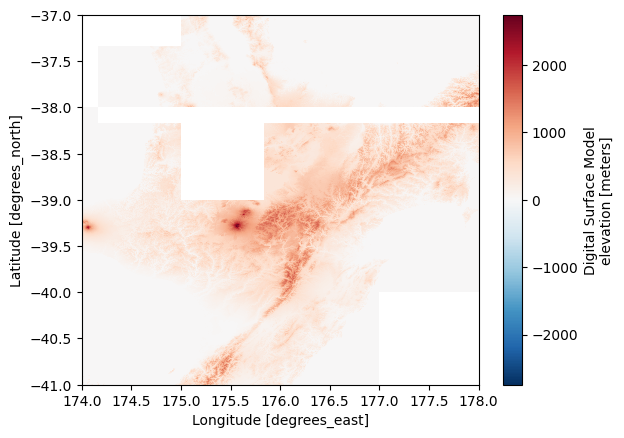

In [12]:
ds['elevation'].sel(longitude=slice(174, 178), latitude=slice(-37, -41), method="nearest").plot()

Apparently New Zealand has at least one point below sea level, which is why xarray has defaulted to a diverging colormap. We can override this to make a more informative plot:

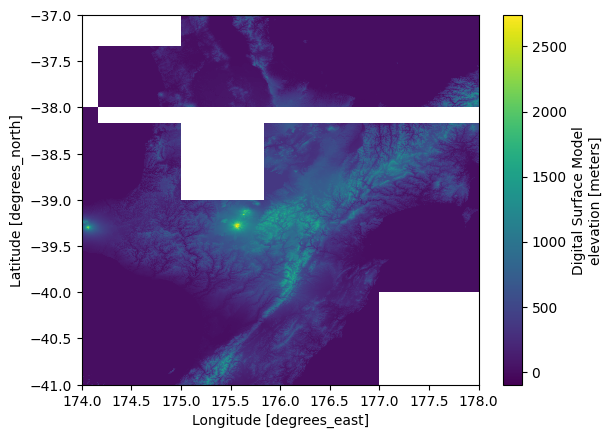

In [13]:
ds['elevation'].sel(longitude=slice(174, 178), latitude=slice(-37, -41), method="nearest").plot(vmin=-100, center=False)

## Coarsen

We could plot the elevation over the whole of NZ at our full resolution, but that would involve downloading >1GB of data to the machine our notebook is running on. That's totally possible, but what if we just wanted to work with a coarsened view of the data, for example for a regional climate model?

We can achieve that very easily using [xarray's `.coarsen` functionality](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays). 

Here we coarsen the data by taking a mean over boxes of 400x400 lat-lon points.

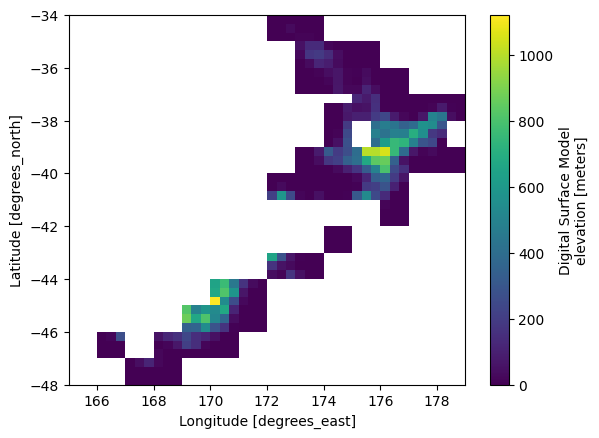

In [14]:
ds['elevation'].coarsen(latitude=400, longitude=400).mean().plot()

## Explore another repo (`era5-surface-aws`)

Let's explore another repo. Earthmover maintains some public datasets - let's list them.

In [5]:
# requires arraylake v0.23.1 for nice HTML repr
client.list_repos(org="earthmover-public")

Name,Created,Updated,Kind,Description,Metadata,Status
gfs,2025-08-28T21:59:37+00:00,2025-09-03T21:15:50+00:00,icechunk,An up-to-date subset of GFS forecast data automatically ingested every six hours,source: NCEP,online
hrrr,2025-08-28T21:30:22+00:00,2025-08-28T22:25:05+00:00,icechunk,An up-to-date subset of HRRR forecast data automatically ingested every hour,source: NCEP,online
era5-surface-aws,2025-07-07T15:03:56+00:00,2025-08-08T12:14:50+00:00,icechunk,Surface variables from the ECMWF ERA5 reanalysis for 1975-2025. See documentation at https://docs.earthmover.io/sample-data/era5 to get started.,source: ECMWFpurpose: analytics,online
aifs-initial-conditions,2025-06-19T16:08:32+00:00,2025-07-10T16:58:11+00:00,icechunk,Initial conditions for AIFS on the native Gaussian grid. Coverage 2025-01-01 through present.,source: ECMWFpurpose: inference,online
aifs-outputs,2025-06-26T19:25:36+00:00,2025-07-10T16:57:17+00:00,icechunk,Outputs from ECMWF AIFS Forecast Model,source: Earthmoverpurpose: analytics,online


Again we can access data in any of these repos lazily via xarray, zarr and icechunk.

Let's have a look at the ERA5 data.

In [6]:
ic_repo = client.get_repo("earthmover-public/era5-surface-aws")
session = ic_repo.readonly_session("main")

In [8]:
ds = xr.open_dataset(session.store, group="spatial", engine="zarr", zarr_format=3)
ds

<xarray.Dataset> Size: 33TB
Dimensions:    (time: 438312, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
Data variables: (12/18)
    blh        (time, latitude, longitude) float32 2TB ...
    cape       (time, latitude, longitude) float32 2TB ...
    sp         (time, latitude, longitude) float32 2TB ...
    skt        (time, latitude, longitude) float32 2TB ...
    d2         (time, latitude, longitude) float32 2TB ...
    sd         (time, latitude, longitude) float32 2TB ...
    ...         ...
    tcwv       (time, latitude, longitude) float32 2TB ...
    u100       (time, latitude, longitude) float32 2TB ...
    v10        (time, latitude, longitude) float32 2TB ...
    tcc        (time, latitude, longitude) float32 2TB ...
    u10        (time, latitude, longitude) float32 2TB ...
    v100       (time, latitude, longitude) float32 2TB ...
Attributes:
    DATA_SOURCE:  ECMWF: https://cds.climate.copernicus.eu, Copernicus Climat...
    Conventions:  CF-1.6
    history:      Created by Earthmover PBC on 2025-07-07 22:26:57 by combini...

A lot more data in here! How much data...?

In [9]:
ds.nbytes / 1e12

32.765263187144

Wow there's 32TB in here!

## Total cloud cover

This dataset has lots of interesting variables, but let's try plotting just one first - total cloud cover. We can look at the metadata of the `tcc` variable to confirm that that's the one that represents total cloud cover.

In [22]:
ds["tcc"].attrs

{'long_name': 'Total cloud cover',
 'short_name': 'tcc',
 'units': '(0-1)',
 'original_format': 'WMO GRIB 1 with ECMWF local table',
 'ecmwf_local_table': 128,
 'ecmwf_parameter': 164,
 'minimum_value': 0.0,
 'maximum_value': 1.0,
 'grid_specification': '0.25 degree x 0.25 degree from 90N to 90S and 0E to 359.75E (721 x 1440 Latitude/Longitude)',
 'rda_dataset': 'ds633.0',
 'rda_dataset_url': 'https:/rda.ucar.edu/datasets/ds633.0/',
 'rda_dataset_doi': 'DOI: 10.5065/BH6N-5N20',
 'rda_dataset_group': 'ERA5 atmospheric surface analysis [netCDF4]',
 'QuantizeGranularBitGroomNumberOfSignificantDigits': 7}

Now as this dataset is global, we should pick a map projection to use, for which we need the `cartopy` library.

In [10]:
import cartopy.crs as ccrs

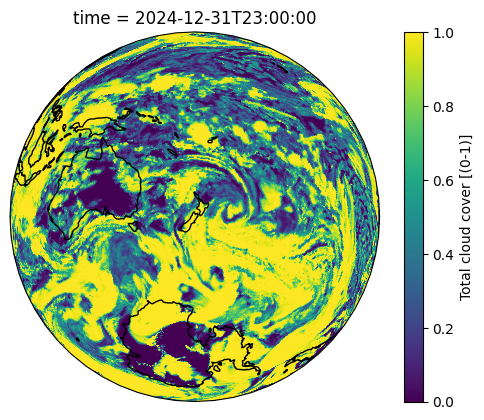

In [11]:
p = ds["tcc"].isel(time=-1).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(173, -42), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
p.axes.set_global()
p.axes.coastlines();

The total cloud cover over New Zealand on New Year's Eve 2024!

### Vorticity

Let's try calculating and plotting a simple derived quantity that you hopefully remember from GFD classes - vorticity.

In [18]:
def vorticity(u, v):
    """
    Calculate the vertical component of vorticity from horizontal velocity fields u and v.
    """

    du_dy = u.differentiate("latitude")
    dv_dx = v.differentiate("longitude")
    
    return dv_dx - du_dy

(This operation will compute eagerly, so we need to select just the timestep we want first, otherwise we will load ~4TB of data into memory! To do this lazily or in parallel for the entire dataset, we would need to take advantage of xarray's integration with parallel computing frameworks such as [Dask](https://docs.xarray.dev/en/stable/user-guide/dask.html).)

In [19]:
final_timestep = ds.isel(time=-1)

In [20]:
vort100 = vorticity(
    u=final_timestep['u100'],
    v=final_timestep['v100'],
)

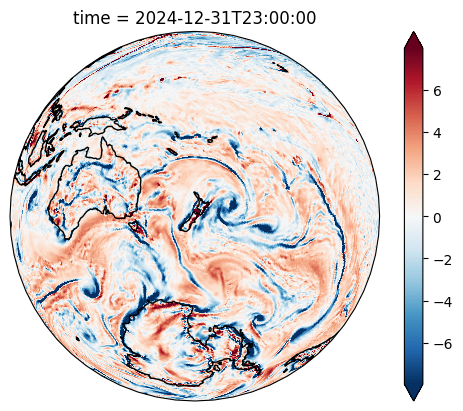

In [21]:
p = vort100.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(173, -42), facecolor="gray"),
    transform=ccrs.PlateCarree(),
    robust=True,
)
p.axes.set_global()
p.axes.coastlines();

The reason this is all so fast is because xarray is only requesting the zarr chunks that it needs to make the plot, and Icechunk's IO layer is capable of fetching them extremely efficiently and concurrently.

## Conclusion

Hopefully this gives you a little taste of how easy it is to find and explore data with the combination of arraylake, icechunk, zarr, and xarray!